# Multimodal Retrieval-Augmented Generation (RAG) with Document Retrieval (ColPali) and Vision Language Models (VLMs)

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_



**🚨 WARNING**: This notebook is resource-intensive and requires substantial computational power. If you're running this in Colab, it will utilize an A100 GPU.

In this notebook, we demonstrate how to build a **Multimodal Retrieval-Augmented Generation (RAG)** system by combining the [**ColPali**](https://huggingface.co/blog/manu/colpali) retriever for document retrieval with the [**Qwen2-VL**](https://qwenlm.github.io/blog/qwen2-vl/) Vision Language Model (VLM). Together, these models form a powerful RAG system capable of enhancing query responses with both text-based documents and visual data.

Instead of relying on a complex document processor pipeline that extracts data through OCR, we will leverage a Document Retrieval Model to efficiently retrieve the relevant documents based on a specific user query.

I also recommend checking out and starring the [smol-vision](https://github.com/merveenoyan/smol-vision) repository, which inspired this notebook—especially [this notebook](https://github.com/merveenoyan/smol-vision/blob/main/ColPali_%2B_Qwen2_VL.ipynb). For an introduction to RAG, you can check [this other cookbook](rag_zephyr_langchain)!





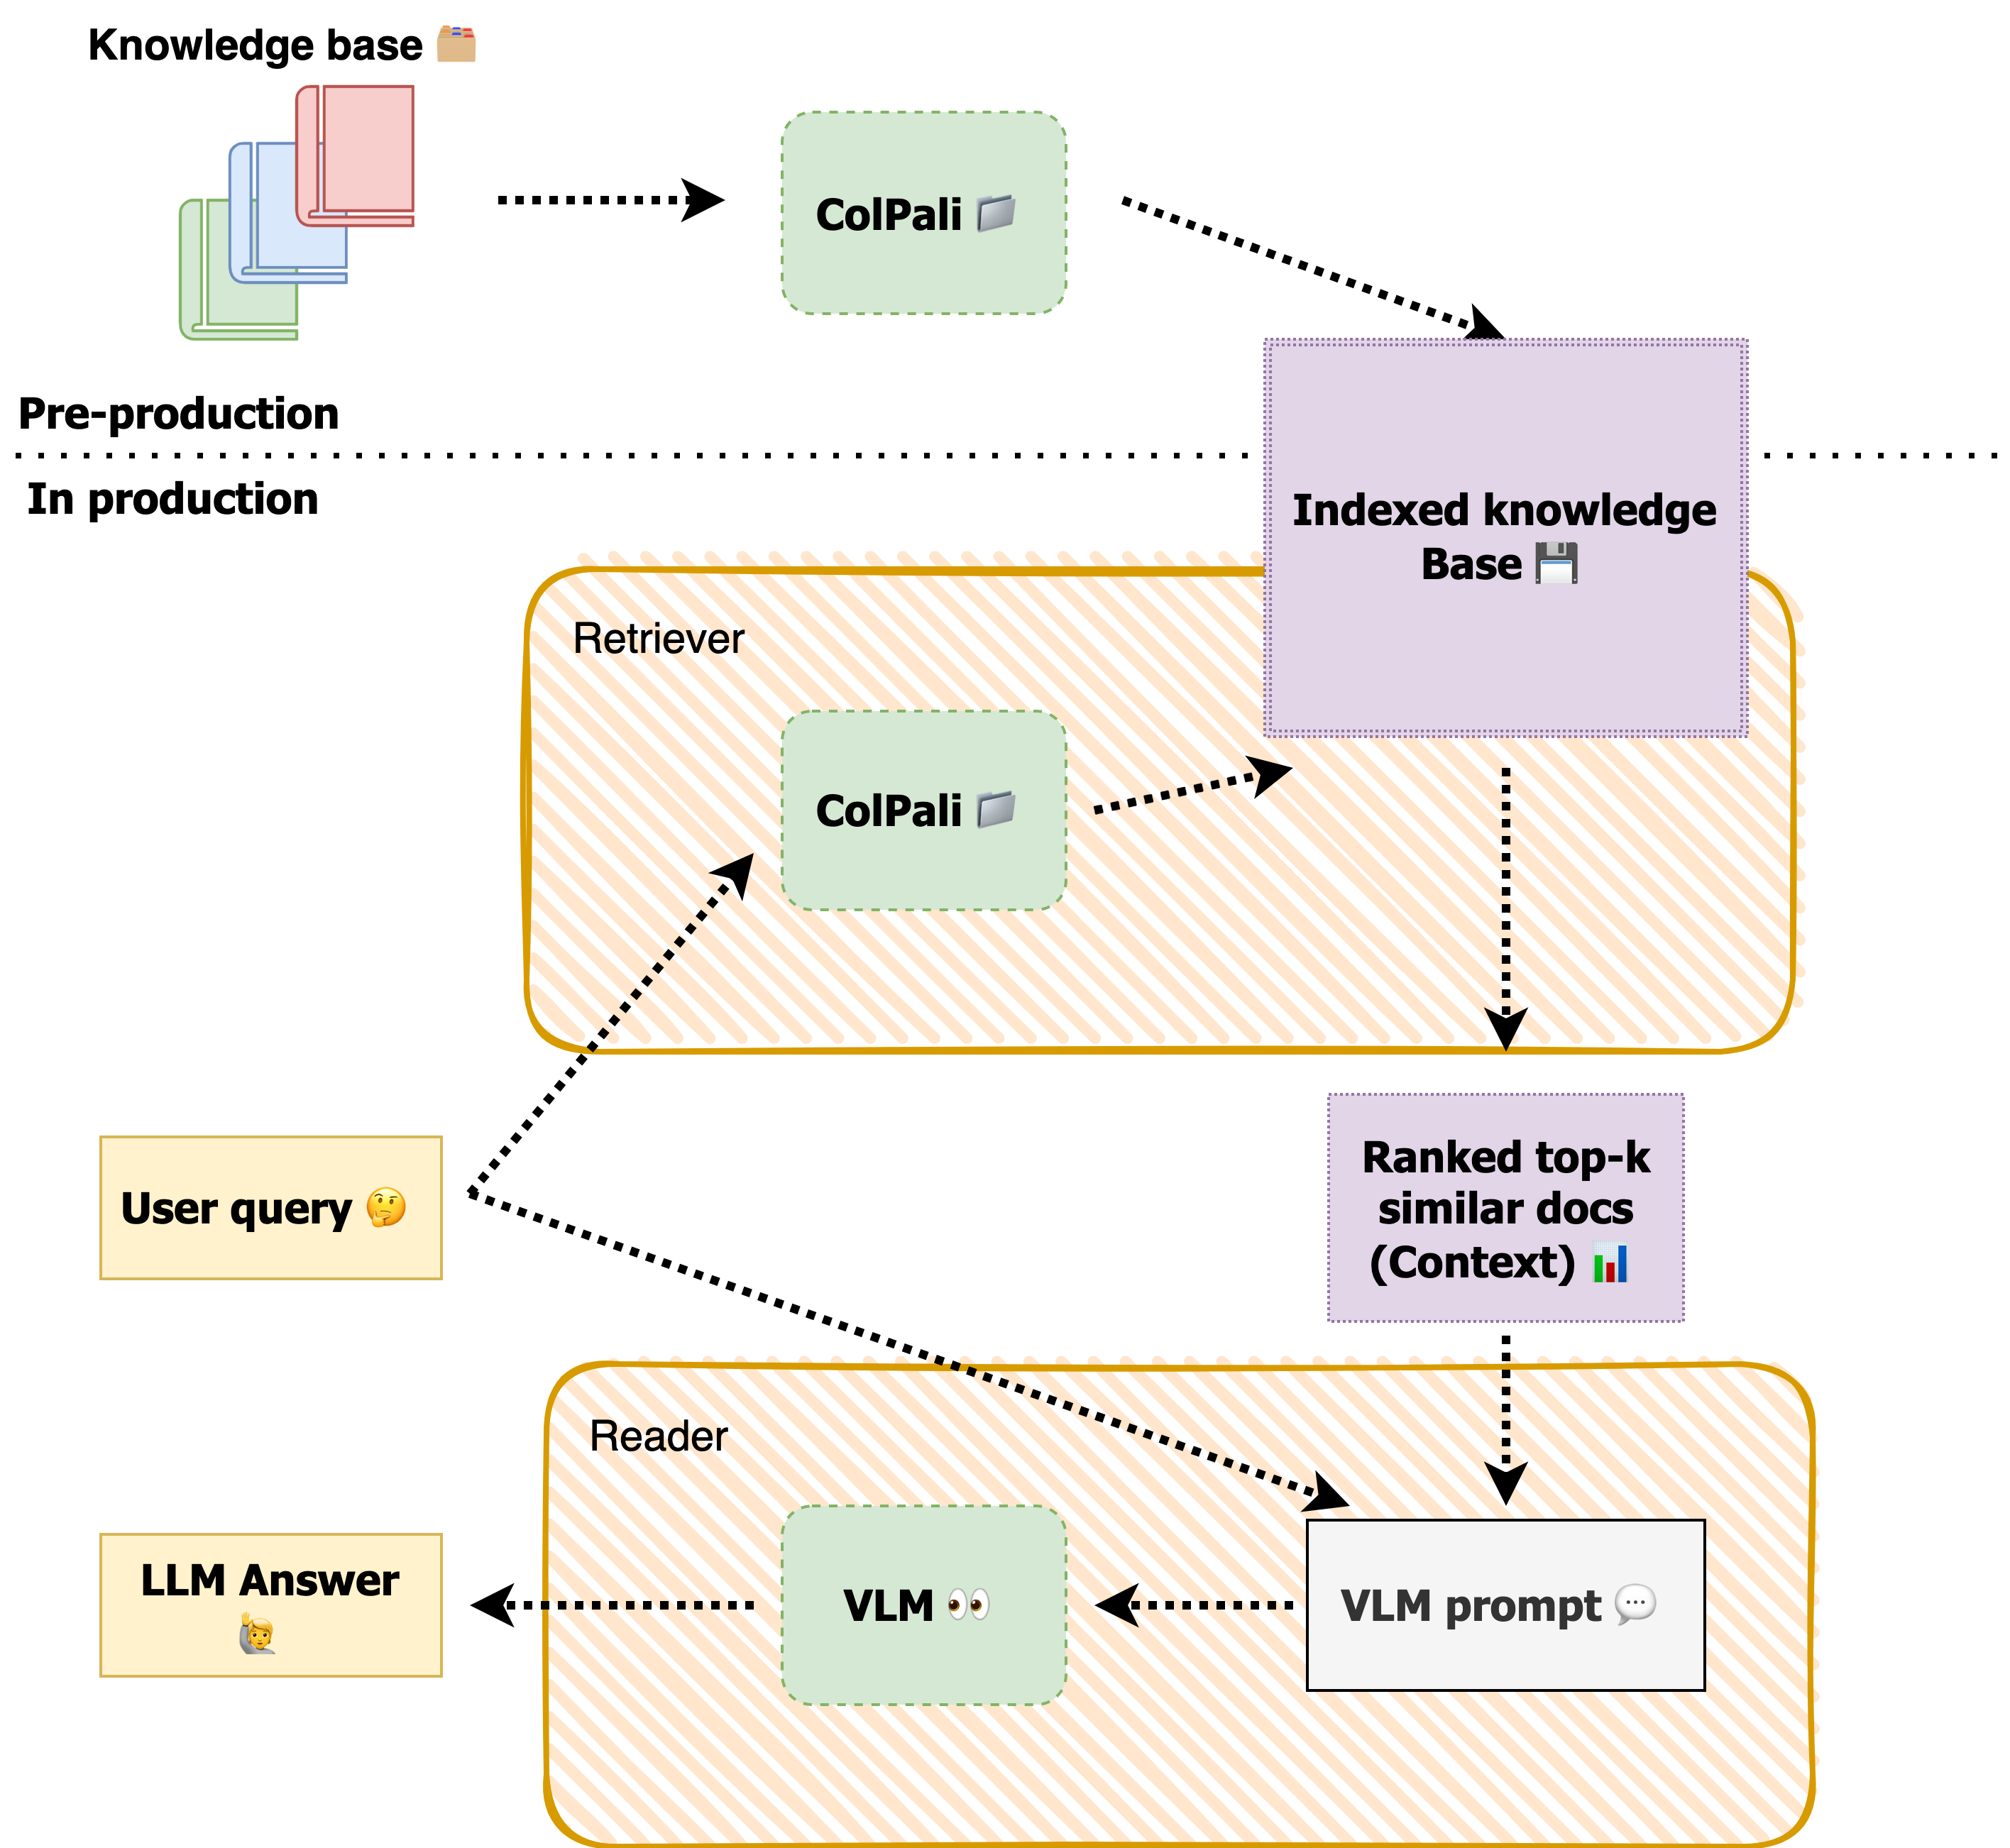

This diagram is inspired by [Aymeric Roucher's](https://huggingface.co/m-ric) work in the [Advanced RAG](https://huggingface.co/learn/cookbook/advanced_rag) or [RAG Evaluation](https://huggingface.co/learn/cookbook/rag_evaluation) recipes.


## 1. Install dependencies

Let’s kick off by installing the essential libraries for our project! 🚀



In [1]:
!pip install -U -q byaldi pdf2image qwen-vl-utils transformers
# Tested with byaldi==0.0.4, pdf2image==1.17.0, qwen-vl-utils==0.0.8, transformers==4.45.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00
 

In [2]:
!pip install fsspec==2025.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.12.0
    Uninstalling fsspec-2024.12.0:
      Successfully uninstalled fsspec-2024.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.


We will also install **poppler-utils** to facilitate PDF manipulation. This utility provides essential tools for working with PDF files, ensuring we can efficiently handle any document-related tasks in our project.


In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
!sudo apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 0s (791 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 126213 

## 2. Load Dataset 📁

In this section, we will utilize IKEA assembly instructions as our dataset. These PDFs contain step-by-step guidance for assembling various furniture pieces. Imagine being able to ask our assistant for help while assembling your new IKEA furniture! 🛋

To download the assembly instructions, you can follow [these steps](https://www.ikea.com/us/en/customer-service/assembly-instructions-puba2cdc880).

For this notebook, I've selected a few examples, but in a real-world scenario, we could work with a large collection of PDFs to enhance our model’s capabilities.


In [5]:
import requests
import os

pdfs = {
    "MALM": "https://www.ikea.com/us/en/assembly_instructions/malm-4-drawer-chest-white__AA-2398381-2-100.pdf",
    "BILLY": "https://www.ikea.com/us/en/assembly_instructions/billy-bookcase-white__AA-1844854-6-2.pdf",
    "BOAXEL": "https://www.ikea.com/us/en/assembly_instructions/boaxel-wall-upright-white__AA-2341341-2-100.pdf",
    "ADILS": "https://www.ikea.com/us/en/assembly_instructions/adils-leg-white__AA-844478-6-2.pdf",
    "MICKE": "https://www.ikea.com/us/en/assembly_instructions/micke-desk-white__AA-476626-10-100.pdf"
}

output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

for name, url in pdfs.items():
    response = requests.get(url)
    pdf_path = os.path.join(output_dir, f"{name}.pdf")

    with open(pdf_path, "wb") as f:
        f.write(response.content)

    print(f"Downloaded {name} to {pdf_path}")

print("Downloaded files:", os.listdir(output_dir))

Downloaded MALM to data/MALM.pdf
Downloaded BILLY to data/BILLY.pdf
Downloaded BOAXEL to data/BOAXEL.pdf
Downloaded ADILS to data/ADILS.pdf
Downloaded MICKE to data/MICKE.pdf
Downloaded files: ['MICKE.pdf', 'BOAXEL.pdf', 'MALM.pdf', 'BILLY.pdf', 'ADILS.pdf']


After downloading the assembly instructions, we will convert the PDFs into images. This step is crucial, as it allows the document retrieval model (ColPali) to process and manipulate the visual content effectively.


In [6]:
import os
from pdf2image import convert_from_path


def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[doc_id] = images

    return all_images

all_images = convert_pdfs_to_images("/content/data/")

Let’s visualize a sample assembly guide to get a sense of how these instructions are presented! This will help us understand the format and layout of the content we’ll be working with. 👀


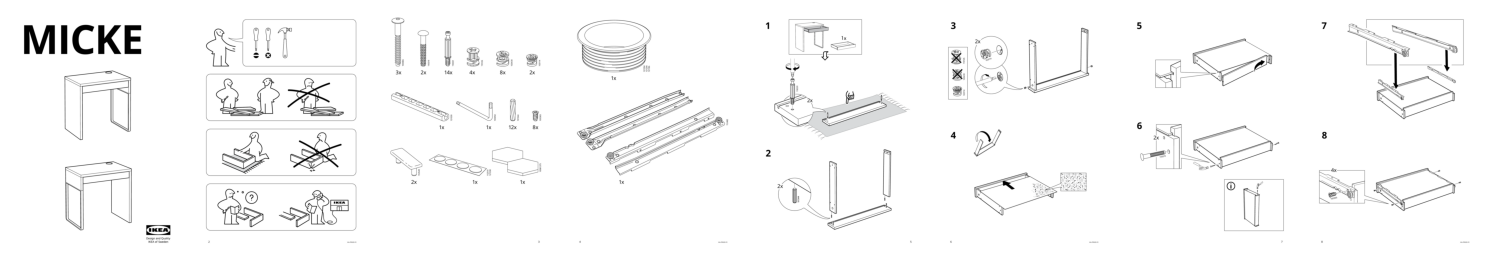

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = all_images[0][i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Initialize the ColPali Multimodal Document Retrieval Model 🤖


Now that our dataset is ready, we will initialize the Document Retrieval Model, which will be responsible for extracting relevant information from the raw images and providing us with the appropriate documents based on our queries.

By utilizing this model, we can significantly enhance our conversational capabilities.

For this task, we will use **[Byaldi](https://github.com/AnswerDotAI/byaldi)**. The developers describe the library as follows: _"Byaldi is RAGatouille's mini sister project. It is a simple wrapper around the ColPali repository to make it easy to use late-interaction multi-modal models such as ColPALI with a familiar API."_

In this project, we will specifically focus on **ColPali**.

![ColPali architecture](https://github.com/illuin-tech/colpali/blob/main/assets/colpali_architecture.webp?raw=true)

Additionally, you can explore **[ViDore (The Visual Document Retrieval Benchmark)](https://huggingface.co/spaces/vidore/vidore-leaderboard)** to see the top-performing retrievers in action.


First, we will load the model from the checkpoint.


In [8]:
from transformers import BitsAndBytesConfig
from byaldi import RAGMultiModalModel

In [9]:
!pip install -U bitsandbytes
!pip install bitsandbytes
!pip install -U accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.5.2
    Uninstalling accelerate-1.5.2:
      Successfully uninstalled accelerate-1.5.2


In [11]:
# 使用4-bit量化配置
bnb_config = BitsAndBytesConfig(load_in_4bit=True, quantization_method="bnb")


In [10]:
from byaldi import RAGMultiModalModel

docs_retrieval_model = RAGMultiModalModel.from_pretrained(
    "vidore/colpali-v1.2")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

Next, we can directly index our documents using the document retrieval model by specifying the folder where the PDFs are stored. This will allow the model to process and organize the documents for efficient retrieval based on our queries.


In [11]:
docs_retrieval_model.index(
    input_path="data/",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

Indexing file: data/MICKE.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Index exported to .byaldi/image_index
Indexing file: data/BOAXEL.pd

{0: 'data/MICKE.pdf',
 1: 'data/BOAXEL.pdf',
 2: 'data/MALM.pdf',
 3: 'data/BILLY.pdf',
 4: 'data/ADILS.pdf'}

## 4. Retrieving Documents with the Document Retrieval Model 🤔

Having initialized the document retrieval model, we can now test its capabilities by submitting a user query and examining the relevant documents it retrieves.

The model will return the results, ranked directly by their relevance to the query.

Let’s give it a try!

In [12]:
text_query = "How many people are needed to assemble the Malm?"

results = docs_retrieval_model.search(text_query, k=3)
results

[{'doc_id': 2, 'page_num': 1, 'score': 14.3125, 'metadata': {}, 'base64': None},
 {'doc_id': 2, 'page_num': 3, 'score': 11.875, 'metadata': {}, 'base64': None},
 {'doc_id': 3, 'page_num': 13, 'score': 11.625, 'metadata': {}, 'base64': None}]

Now, let’s examine the specific documents (images) that the model has retrieved. This will allow us to see the visual content that corresponds to our query and understand how the model selects relevant information.


In [13]:
def get_grouped_images(results, all_images):
    grouped_images = []

    for result in results:
        doc_id = result['doc_id']
        page_num = result['page_num']
        grouped_images.append(all_images[doc_id][page_num - 1]) # page_num are 1-indexed, while doc_ids are 0-indexed. Source https://github.com/AnswerDotAI/byaldi?tab=readme-ov-file#searching

    return grouped_images

grouped_images = get_grouped_images(results, all_images)

Let’s take a closer look at the retrieved documents to understand the information they contain. This examination will help us evaluate the relevance and quality of the retrieved content in relation to our query.


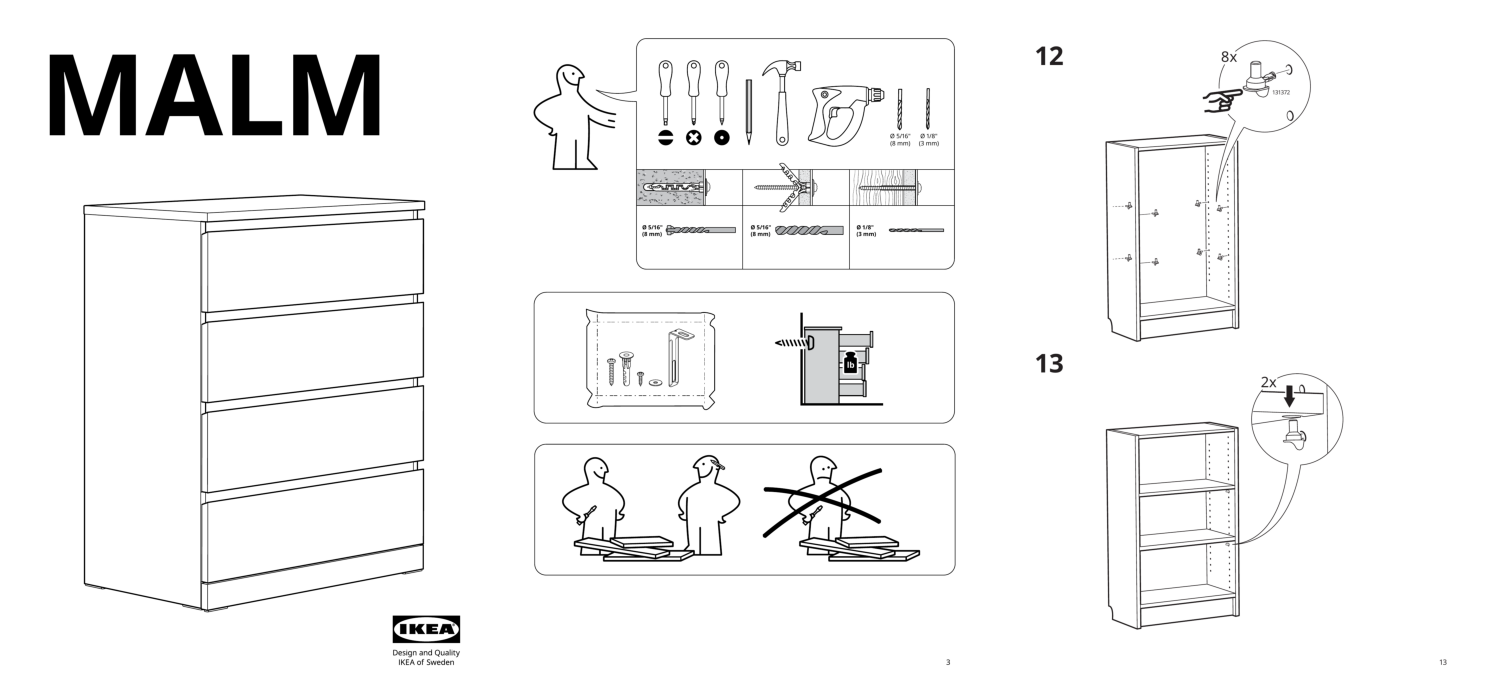

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = grouped_images[i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Initialize the Visual Language Model for Question Answering 🙋

Next, we will initialize the Visual Language Model (VLM) that we will use for question answering. In this case, we’ll be utilizing **[Qwen2_VL](https://huggingface.co/docs/transformers/main/en/model_doc/qwen2_vl)**.

![Qwen2_VL architecture](https://qianwen-res.oss-accelerate-overseas.aliyuncs.com/Qwen2-VL/qwen2_vl.jpg)

You can check the leaderboard for Open VLM to stay updated on the latest advancements [here](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard).

First, we will load the model from the pretrained checkpoint and move it to the GPU for optimal performance. See the model [here](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct).


In [18]:
!pip install -U bitsandbytes

In [13]:
!pip install transformers_stream_generator

  Preparing metadata (setup.py) ... done
  Created wheel for transformers_stream_generator: filename=transformers_stream_generator-0.0.5-py3-none-any.whl size=12426 sha256=b743cf1c73978f81e8ea2dcb947c7ebc0ddb6cbd4c02ffa57230c03a5dc16b70
  Stored in directory: /root/.cache/pip/wheels/23/e8/f0/b3c58c12d1ffe60bcc8c7d121115f26b2c1878653edfca48db
Successfully built transformers_stream_generator


In [14]:
!pip install -U flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 50.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.4.post1-cp311-cp311-linux_x86_64.whl size=187831595 sha256=58853b28a5a926cae14402bfd8d4d93a45ebf8f9e79533f37ab09d0d77a99c05
  Stored in directory: /root/.cache/pip/wheels/3d/88/d8/284b89f56af7d5bf366b10d6b8e251ac8a7c7bf3f04203fb4f
Successfully built flash-attn


In [1]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
!pip install -U bitsandbytes
!pip install -U accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.5.2
    Uninstalling accelerate-1.5.2:
      Successfully uninstalled accelerate-1.5.2


In [1]:
import bitsandbytes as bnb
print("bitsandbytes version:", bnb.__version__)


ModuleNotFoundError: No module named 'bitsandbytes'

In [18]:
!pip install bitsandbytes

In [17]:
!pip install -U bitsandbytes

In [16]:
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info
import torch
from transformers import BitsAndBytesConfig

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,  # 或 torch.float16
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="fp4",
)

vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    device_map="auto",
    quantization_config=quant_config
)
vl_model.eval()

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

ImportError: Using `bitsandbytes` 4-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

Next, we will initialize the VLM processor. In this step, we specify the minimum and maximum pixel sizes to optimize the fitting of more images into the GPU memory.

For further details on optimizing image resolution for performance, you can refer to the documentation [here](https://huggingface.co/docs/transformers/main/en/model_doc/qwen2_vl#image-resolution-for-performance-boost).


In [8]:
min_pixels = 224*224
max_pixels = 1024*1024
vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

## 6. Assembling the VLM Model and Testing the System 🔧

With all components loaded, we can now assemble the system for testing. First, we will create the chat structure by providing the system with the three retrieved images along with the user query. This step can be customized to fit your specific needs, allowing for greater flexibility in how you interact with the model!

In [19]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": grouped_images[0],
            },
            {
                "type": "image",
                "image": grouped_images[1],
            },
            {
                "type": "image",
                "image": grouped_images[2],
            },
            {
                "type": "text",
                "text": text_query
            },
        ],
    }
]

Now, let's apply this chat structure.


In [20]:
text = vl_model_processor.apply_chat_template(
    chat_template, tokenize=False, add_generation_prompt=True
)

Next, we will process the inputs to ensure they are properly formatted and ready to be used as input for the Visual Language Model (VLM). This step is essential for enabling the model to effectively generate responses based on the provided data.

In [21]:
image_inputs, _ = process_vision_info(chat_template)
inputs = vl_model_processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

We are now ready to generate the answer! Let’s see how the system utilizes the processed inputs to provide a response based on the user query and the retrieved images.


In [22]:
!nvidia-smi

Sun Apr  6 19:39:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             50W /  400W |   13137MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [24]:
generated_ids = vl_model.generate(
    **inputs,
    max_new_tokens=128,
    use_cache=False,           # 显著减少显存占用
    do_sample=False,           # 贪婪解码，控制输出稳定
    temperature=0.7,           # 控制多样性（do_sample=True 时才有效）
    top_p=0.9,                 # 样本多样性（备用）
    repetition_penalty=1.1     # 减少重复

    )

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.28 GiB. GPU 0 has a total capacity of 39.56 GiB of which 12.07 GiB is free. Process 28574 has 27.48 GiB memory in use. Of the allocated memory 26.71 GiB is allocated by PyTorch, and 277.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Once the model has generated the output, we postprocess it to generate the final answer.

In [ ]:
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [ ]:
print(output_text[0])

The Malm requires two people to assemble it.


## 7. Assembling It All! 🧑‍🏭️

Now, let’s create a method that encompasses the entire pipeline, allowing us to easily reuse it in future applications.


In [ ]:
def answer_with_multimodal_rag(vl_model, docs_retrieval_model, vl_model_processor, grouped_images, text_query, top_k, max_new_tokens):
    results = docs_retrieval_model.search(text_query, k=top_k)
    grouped_images = get_grouped_images(results, all_images)

    chat_template = [
    {
      "role": "user",
      "content": [
          {"type": "image", "image": image} for image in grouped_images
            ] + [
          {"type": "text", "text": text_query}
        ],
      }
    ]

    # Prepare the inputs
    text = vl_model_processor.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(chat_template)
    inputs = vl_model_processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Generate text from the vl_model
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # Decode the generated text
    output_text = vl_model_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text

Let’s take a look at how the complete RAG system operates!


In [ ]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    grouped_images=grouped_images,
    text_query="How do I assemble the Micke desk?",
    top_k=3,
    max_new_tokens=500
)
print(output_text[0])

To assemble the Micke desk, follow these steps:

1. **Prepare the Components**: Lay out all the components of the desk on a flat surface.

2. **Attach the Legs**: Place the legs on the bottom of the desk frame. Ensure they are securely attached.

3. **Attach the Top**: Place the top of the desk on the frame, making sure it is level and stable.

4. **Secure with Screws**: Use the provided screws to secure the top to the frame. Ensure all screws are tightened securely.

5. **Final Check**: Double-check that all parts are properly attached and the desk is stable.

Refer to the detailed instructions provided in the image for specific steps and any additional information needed for assembly.


🏆 We now have a fully operational RAG pipeline that leverages both a Document Retrieval Model and a Visual Language Model! This powerful combination enables us to generate insightful responses based on user queries and relevant documents.



## 8. Continuing the Journey 🧑‍🎓️

This recipe is just the starting point in exploring the potential of multimodal RAG systems. If you're eager to dive deeper, here are some ideas and resources to guide your next steps:

### 🔍 Explore Further with ColPali:
- [Document Similarity Search with ColPali](https://huggingface.co/blog/fsommers/document-similarity-colpali)
- [ColPali Cookbooks 👀](https://github.com/tonywu71/colpali-cookbooks/tree/main)
- [ColPali Fine-Tuning Query Generator](https://huggingface.co/spaces/davanstrien/ColPali-Query-Generator)
- [Generating a Query Dataset for Fine-Tuning ColPali on a UFO Dataset](https://danielvanstrien.xyz/posts/post-with-code/colpali/2024-09-23-generate_colpali_dataset.html)

### 📖 Additional Reads:
- [Beyond Text: The Rise of Vision-Driven Document Retrieval for RAG](https://blog.vespa.ai/the-rise-of-vision-driven-document-retrieval-for-rag/)
- [Scaling ColPali to Billions of PDFs with Vespa](https://blog.vespa.ai/scaling-colpali-to-billions/)

### 💡 Useful Collections:
- [Multimodal RAG Collection](https://huggingface.co/collections/merve/multimodal-rag-66d97602e781122aae0a5139)

### 📝 The Paper and Original Code:
- [ColPali: Efficient Document Retrieval with Vision Language Models (Paper)](https://arxiv.org/pdf/2407.01449)
- [ColPali: Efficient Document Retrieval with Vision Language Models (Repo)](https://github.com/illuin-tech/colpali)

Feel free to explore these resources as you continue your journey into the world of multimodal retrieval and generation systems!

